Load MNIST dataset and view format

Inspired by https://sagemaker-examples.readthedocs.io/en/latest/aws_sagemaker_studio/sagemaker_algorithms/linear_learner_mnist/linear_learner_mnist.html


In [1]:
# Install libraries

import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/kdevoe/Documents/CS/Projects/roc_curve/roc-curve-exploration/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN = True  # Set to False to skip training and load a pretrained model
INFERENCE = True  # Set to False to skip inference

BATCH_SIZE = 5
EPOCHS = 1

In [3]:
if TRAIN:
    # Import traing and test data

    train_data = pd.read_csv('./data/mnist_train.csv')
    test_data = pd.read_csv('./data/mnist_test.csv')

    # Show the shape of the train and test data
    print('Training data shape: ', train_data.shape)
    print('Test data shape: ', test_data.shape)

Training data shape:  (60000, 785)
Test data shape:  (10000, 785)


Reformat the data to be compatible with 28x28 pixel image inputs. 

Reset the targets to be true or false for whether the number is the target or not.

In [4]:
if TRAIN:
    # Make numpy arrays of the train and test data from the pandas dataframes
    train_data = train_data.to_numpy()
    test_data = test_data.to_numpy()

    # Separate out the targets as the first column of the train data
    train_labels = train_data[:, 0]
    train_inputs = train_data[:, 1:]
    test_labels = test_data[:, 0]
    test_inputs = test_data[:, 1:]

    # Normalize the inputs
    train_inputs = train_inputs / 255.0
    test_inputs = test_inputs / 255.0

    # Reshape the data to be 2D arrays
    train_inputs = train_inputs.reshape(-1, 28, 28)
    test_inputs = test_inputs.reshape(-1, 28, 28)

    TARGET_NUM = 5

    # Reset the train labels to be 1 if it is the target number and 0 if not
    train_labels = (train_labels == TARGET_NUM).astype(np.float32)

    print('Training input data shape: ', train_inputs.shape)
    print('Training labels data shape: ', train_labels.shape)
    print('Test input data shape: ', test_inputs.shape)



Training input data shape:  (60000, 28, 28)
Training labels data shape:  (60000,)
Test input data shape:  (10000, 28, 28)


https://d2l.ai/chapter_convolutional-neural-networks/lenet.html#lenet

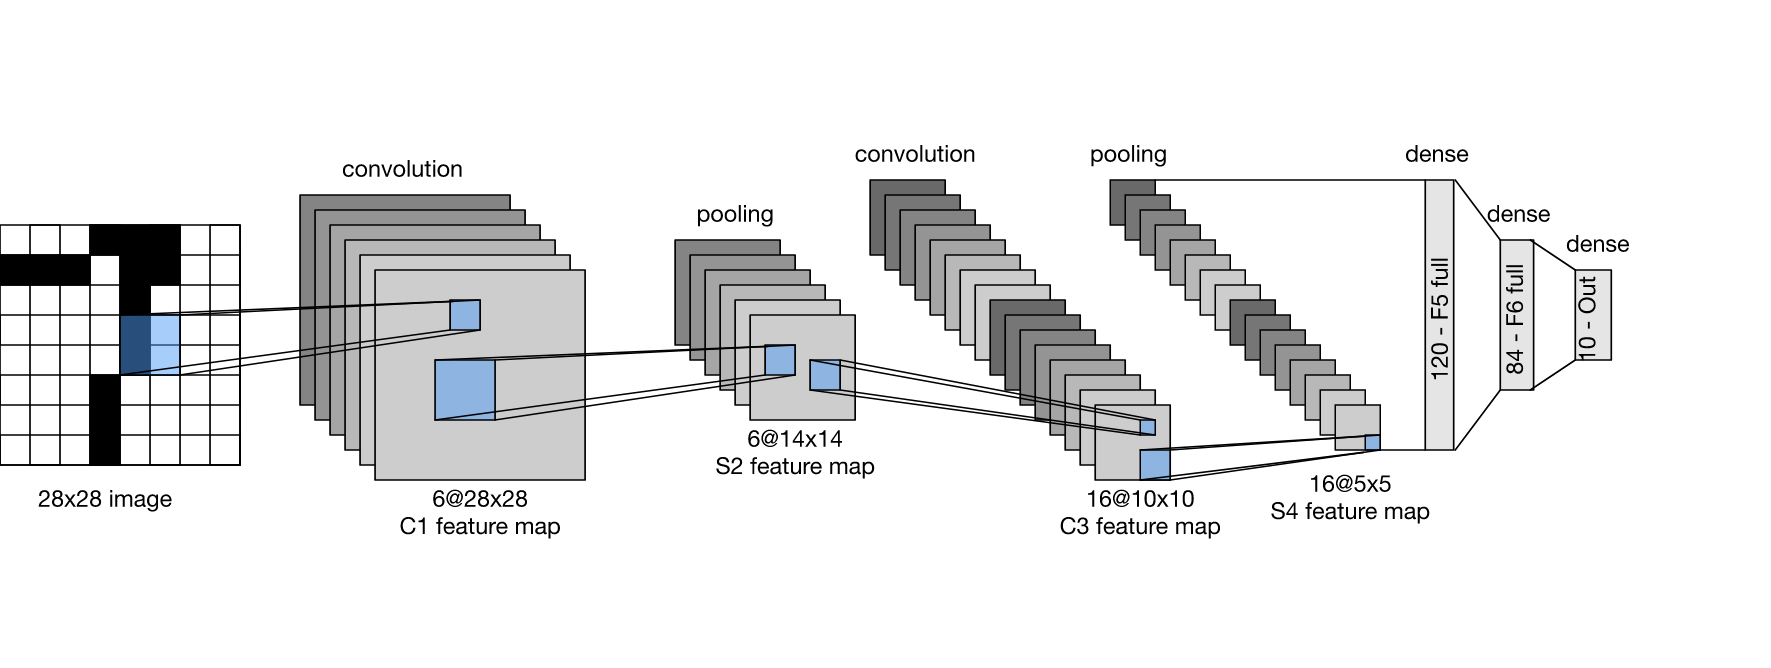

Define a basic LeNet model based on the PyTorch documentation: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
Note: Adjusted padding to be 2 to allow for inputs of 28x28 instead of 32x32.

In [5]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)  # Set padding to 2 to allow for 28x28 inputs
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)  # 1 output for binary classification

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x


net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


Define the optimizer and loss function

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
if TRAIN:
    # Training loop

    def training_loop(num_epochs = EPOCHS):

        num_batches = len(train_inputs) // BATCH_SIZE

        losses = []
        correct = 0
        total_loss = 0

        for epoch in range(num_epochs):  # loop over the dataset for each epoch
            print("Training epoch: ", epoch)
            for batch in tqdm(range(num_batches)):
                # get the inputs; data is a list of [inputs, labels]
                start_index = batch * BATCH_SIZE
                end_index = start_index + BATCH_SIZE
                inputs = torch.from_numpy(train_inputs[start_index: end_index]).float().reshape(BATCH_SIZE, 1, 28, 28)
                labels = torch.from_numpy(train_labels[start_index: end_index].reshape(BATCH_SIZE, -1))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += np.mean(loss.item())

                for i in range(BATCH_SIZE):
                    if (outputs[i] > 0.5) == labels[i]:
                        correct += 1

                frequency = 1000
                if batch % frequency == 0:
                    average_loss = total_loss / frequency
                    #print(f"Average loss over last {frequency} batches: ", average_loss)
                    total_loss = 0
                    losses.append(average_loss)
            
        return losses, correct

    losses, correct = training_loop()

    print('Accuracy: ', correct / len(train_inputs))
    

Training epoch:  0


100%|██████████| 12000/12000 [00:16<00:00, 733.37it/s]

Accuracy:  0.9952666666666666


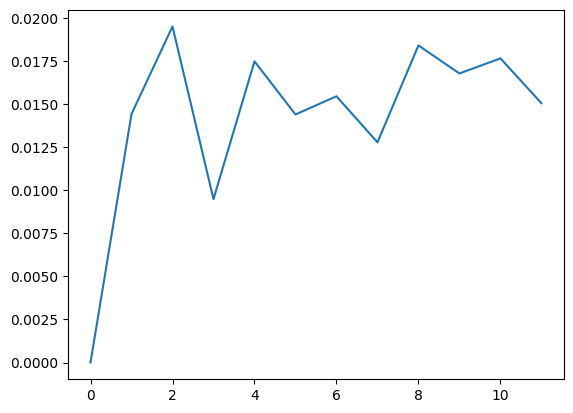

In [10]:
if TRAIN:
    # Save the model
    torch.save(net.state_dict(), './models/lenet_mnist.pth')

    # Plot the training loss
    plt.plot(losses)

In [13]:
if INFERENCE:
    # Load the model
    net.load_state_dict(torch.load('./models/lenet_mnist.pth'))

    # Inference loop

    def inference_loop(threshold=0.5):

        metrics = {}
        metrics['true_pos'] = 0
        metrics['true_neg'] = 0
        metrics['false_pos'] = 0
        metrics['false_neg'] = 0

        num_batches = len(test_inputs) // BATCH_SIZE


        for batch in tqdm(range(num_batches)):
            # get the inputs; data is a list of [inputs, labels]
            start_index = batch * BATCH_SIZE
            end_index = start_index + BATCH_SIZE
            inputs = torch.from_numpy(test_inputs[start_index: end_index]).float().reshape(BATCH_SIZE, 1, 28, 28)
            labels = torch.from_numpy(train_labels[start_index: end_index].reshape(BATCH_SIZE, -1))

            # forward
            predictions = net(inputs)

            for i in range(BATCH_SIZE):
                if predictions[i] > threshold:
                    if labels[i] == 1:
                        metrics['true_pos'] += 1
                    else:
                        metrics['false_pos'] += 1
                else:
                    if labels[i] == 1:
                        metrics['false_neg'] += 1
                    else:
                        metrics['true_neg'] += 1

        return metrics

    metrics = inference_loop()

    print(metrics)

    precision = metrics['true_pos'] / (metrics['true_pos'] + metrics['false_pos'])
    recall = metrics['true_pos'] / (metrics['true_pos'] + metrics['false_neg'])

    print('Precision: ', precision)
    print('Recall: ', recall)

100%|██████████| 2000/2000 [00:00<00:00, 2206.04it/s]

{'true_pos': 77, 'true_neg': 8323, 'false_pos': 814, 'false_neg': 786}
Precision:  0.08641975308641975
Recall:  0.08922363847045191
